# Processing biosignals in Friends Dataset
## physiological data preparation for Courtois-Neuromod
The notebook reviews general steps for the preparation of biosignals collected in the scanner (fMRI). We will firstly load information from processed biosignals, then we will inspect different layers of the pipeline in order to visualize the contribution of each of its parameters. We will give precedence to the PPG signal for parcimony. 

## Friends dataset
General description of the dataset
Physiological data acquisition equipment
Features of interest in the signals and how it can be merged to fMRI data

Table of contents:
1. Quality control summary
2. Inspection of parameters effects
3. Visualization of artefacts and systolic peaks intervals

#### Dependencies

In [1]:
# these are utilities
import pandas as pd
import numpy as np
import os
import glob
import pickle
import pprintpp

In [2]:
# these are biosignal processing packages
import neurokit2 as nk
import systole
import heartpy as hp

In [3]:
# these are visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# here we set our parameters to render figures
%pylab inline
sns.set_style('darkgrid')
pylab.rcParams['figure.figsize'] = (12.0, 6.0)  
plt.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


## 1. Quality Control
We have to fetch features of information from each participant's biosignals. Information loaded here relate to quality of each acquisitions as they contain the number of artefacts detected by the biosignal processing packages. The pipeline will be discussed in further details in the next section.

We breakdown our quality control procedure by following guidelines reported by [Quintanna, Alvares & Heathers, 2016](https://www.nature.com/articles/tp201673) (see Figure 1). Essentially, automatic identification of artefacts and peaks representing any physiological activity in signals are done in parallel using peer-reviewed techniques implemented in open-source packages. All biosignals are processed using [NeuroKit2](), [systole]() and [HeartPy](). Here, they are illustrated alongside in order to compare their annotations of the PPG signal. 

### Definition of artefacts by Tarvainen

**1. Etopic (interval):**

**2. Short (interval):**

**3. Long (interval):**

**4. Extra (peak:**

**5. Missed (peak) :**

In [5]:
# data label
indir = "/scratch/flesp/physio_data/friends1/viz/"
root = "/scratch/flesp/physio_data/friends1/"
sub=['sub-01', 'sub-02','sub-03', 'sub-04','sub-05', 'sub-06']

In [6]:
# Fetching stored data
# iterate through subjects/sessions and print progress
df = pd.DataFrame()
for s in sub:
    print(s)
    print("~"*30)
    meta = pd.read_json(f"{root}/{s}/{s}_volumes_all-ses-runs.json")
    
    for ses in meta.keys():
        print(f"Currently processing {ses}")
        json = glob.glob(f"{indir}{s}/{ses}/*.json")
        json.sort()
        if len(json)==0:
            print('empty session')
        # read each file in a subject/session
        for i, info in enumerate(json):
            here = info.rfind('task')
            there = info.rfind('_')
            task = info[here:there]
            with open(info, 'rb') as f:
                tmp = pickle.load(f)
            try:
                nb_vol=meta[ses][f"{i+1:02d}"]

                if nb_vol is np.nan:
                    nb_vol=int(0)
            except KeyError:
                print(f"skipping {ses} run-{i:02d}")
                continue
            print("fetching run info")
            # create a new row in the dataframe with artefacts count and mean interbeat interval
            new_row = {'ectopic':tmp['PPG_ectopic'], 
                       'short':tmp['PPG_short'], 'extra':tmp['PPG_extra'],
                       'long': tmp['PPG_long'], 'missed':tmp['PPG_missed'], 
                       'mean_rr_systole': np.mean(tmp['PPG_clean_rr_systole']),
                       'std_rr_systole': np.std(tmp['PPG_clean_rr_systole']),
                       'mean_rr_heartpy': np.mean(tmp['PPG_clean_rr_hp']),
                       'RSP_Phase': dict({'RSP_Peaks':tmp['RSP_Peaks'],'RSP_Troughs':tmp['RSP_Troughs']}),
                       'task': task, 'run_id': i+1, 'session_id':ses, 'subject': s,
                       'filename': json[i], 'nb_vol':int(nb_vol)}
            df = df.append(new_row,ignore_index=True)

#df.to_csv('result.csv')

sub-01
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently processing ses-001
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-002
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-003
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-004
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-005
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-006
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-007
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-008
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-009
fetching run info

fetching run info
fetching run info
fetching run info
Currently processing ses-039
empty session
Currently processing ses-040
empty session
Currently processing ses-041
empty session
Currently processing ses-042
empty session
Currently processing ses-043
empty session
sub-03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently processing ses-001
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-002
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-003
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-004
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-005
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-006
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-007
fetching run info
fetching run info
fetching run info
fetc

Currently processing ses-017
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-018
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-019
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-020
empty session
Currently processing ses-021
empty session
Currently processing ses-022
fetching run info
fetching run info
Currently processing ses-023
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-024
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-025
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-026
fetching run info
fetching run info
fetching run info
fetching run inf

/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-015
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-016
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-017
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-018
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-019
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-020
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently proces

In [7]:
quality_df = df[(df['mean_rr_systole']>1200) | ((df['mean_rr_heartpy']<700) & (df['mean_rr_systole']<600)) | (df['std_rr_systole']>300)]
root = "/scratch/flesp/physio_data/friends1/"
for sub in ['sub-01', 'sub-02','sub-03', 'sub-04','sub-05', 'sub-06']:
    meta = pd.read_json(f"{root}/{sub}/{sub}_volumes_all-ses-runs.json")
    
    runs = {}
    ses_to_check = quality_df['session_id'][quality_df['subject']==sub].unique()
    for ses in ses_to_check:
        runs[ses] = list(quality_df['run_id'][quality_df['session_id']==ses])
    for ses in ses_to_check:
        for i in runs[ses]:
            triggers=list(meta[ses]['recorded_triggers'].values())
            triggers=list(np.concatenate(triggers).flat)
            try:
                pprintpp.pprint([sub, ses, int(i),meta[ses]['task'][int(i)], triggers[int(i)], quality_df[(quality_df['subject']==sub) &(quality_df['session_id']==ses) & (quality_df['run_id']==i)]['mean_rr_systole'],
                                 quality_df[(quality_df['subject']==sub) &(quality_df['session_id']==ses) & (quality_df['run_id']==i)]['std_rr_systole']])
                
            except IndexError:
                print(sub, ses, int(i), triggers)

[
    'sub-02',
    'ses-001',
    2,
    'task-s01e02a',
    482,
    191    599.58124
    Name: mean_rr_systole, dtype: float64,
    191    59.215592
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-02',
    'ses-001',
    3,
    'task-s01e02b',
    482,
    192    588.722254
    Name: mean_rr_systole, dtype: float64,
    192    64.579291
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-02',
    'ses-001',
    4,
    'task-s01e03a',
    472,
    193    580.027858
    Name: mean_rr_systole, dtype: float64,
    193    67.785433
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-02',
    'ses-001',
    5,
    'task-s01e03b',
    472,
    194    564.995839
    Name: mean_rr_systole, dtype: float64,
    194    70.27067
    Name: std_rr_systole, dtype: float64,
]
sub-02 ses-001 6 [3, 42, 482, 482, 472, 472, 503, 503]
[
    'sub-02',
    'ses-001',
    3,
    'task-s01e02b',
    482,
    192    588.722254
    Name: mean_rr_systole, dtype: float64,
    192    64.579291
    Na

    'sub-03',
    'ses-028',
    2,
    'task-s03e03a',
    475,
    444    943.75017
    Name: mean_rr_systole, dtype: float64,
    444    566.865089
    Name: std_rr_systole, dtype: float64,
]
sub-03 ses-030 4 [3, 470, 470, 467, 3, 467]
sub-03 ses-032 4 [3, 451, 451, 457, 456]
[
    'sub-03',
    'ses-039',
    3,
    'task-s04e01b',
    3,
    491    1721.273214
    Name: mean_rr_systole, dtype: float64,
    491    3321.026074
    Name: std_rr_systole, dtype: float64,
]
sub-03 ses-039 4 [3, 479, 479, 3, 468, 468]
sub-03 ses-040 4 [3, 478, 478, 445, 445]
[
    'sub-03',
    'ses-045',
    1,
    'task-s04e12b',
    466,
    513    909.073238
    Name: mean_rr_systole, dtype: float64,
    513    401.667181
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-03',
    'ses-046',
    1,
    'task-s04e14b',
    5,
    517    52037.223077
    Name: mean_rr_systole, dtype: float64,
    517    60090.253014
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-03',
    'ses-046',
    2,
 

In [10]:
clean_df = df.drop(df[(df['mean_rr_systole']>1200) | ((df['mean_rr_heartpy']<700) & (df['mean_rr_systole']<600)) | (df['std_rr_systole']>300)].index)
#clean_df = df
#clean_df.to_csv("/scratch/flesp/physio_data/friends1/pilot_hr-isc.csv")

<AxesSubplot:xlabel='std_rr_systole', ylabel='Count'>

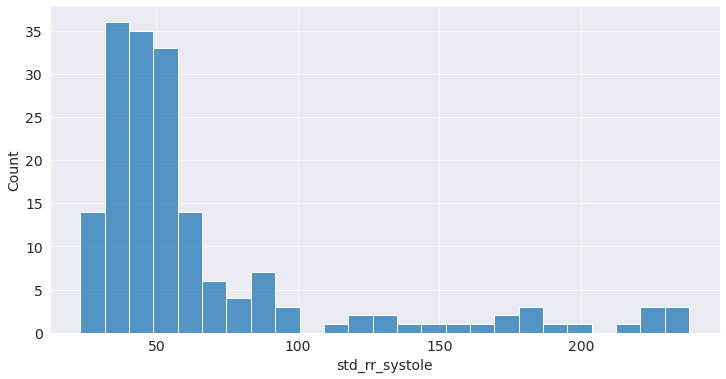

In [11]:
sns.histplot(data=clean_df[(clean_df['subject']=='sub-04')], x='std_rr_systole')

In [12]:
ok_task=[]
for task in pd.unique(clean_df['task'].unique()):
    tmp = clean_df[clean_df['task']==task]
    if len(tmp)>=4:
        ok_task.append(task)
        
print(len(ok_task), len(pd.unique(clean_df['task'].unique())))

174 237


In [13]:
ok_task.sort()

In [14]:
ok_task

['',
 'task-s01e01a',
 'task-s01e01b',
 'task-s01e02a',
 'task-s01e02b',
 'task-s01e03a',
 'task-s01e03b',
 'task-s01e04a',
 'task-s01e04b',
 'task-s01e05a',
 'task-s01e05b',
 'task-s01e06a',
 'task-s01e06b',
 'task-s01e07a',
 'task-s01e07b',
 'task-s01e08a',
 'task-s01e08b',
 'task-s01e09a',
 'task-s01e09b',
 'task-s01e10a',
 'task-s01e10b',
 'task-s01e11a',
 'task-s01e11b',
 'task-s01e12a',
 'task-s01e12b',
 'task-s01e13a',
 'task-s01e13b',
 'task-s01e14a',
 'task-s01e14b',
 'task-s01e15a',
 'task-s01e15b',
 'task-s01e16a',
 'task-s01e16b',
 'task-s01e17a',
 'task-s01e17b',
 'task-s01e18a',
 'task-s01e18b',
 'task-s01e19a',
 'task-s01e19b',
 'task-s01e20a',
 'task-s01e20b',
 'task-s01e21a',
 'task-s01e21b',
 'task-s01e22a',
 'task-s01e22b',
 'task-s01e23a',
 'task-s01e23b',
 'task-s01e24a',
 'task-s01e24b',
 'task-s02e01a',
 'task-s02e01b',
 'task-s02e02a',
 'task-s02e02b',
 'task-s02e03a',
 'task-s02e03b',
 'task-s02e04a',
 'task-s02e04b',
 'task-s02e05a',
 'task-s02e05b',
 'task-s0

# 2. Processing

#### Import home functions

In [15]:
%run ~/cneuromod/ds_prep/physio/preproc/neuromod_process.py

<Figure size 864x432 with 0 Axes>

#### Fetch data

In [30]:
fn = "/scratch/flesp/physio_data/friends1/sub-06/sub-06_volumes_all-ses-runs.json"
metadata = pd.read_json(fn)
filename = "/scratch/flesp/physio_data/friends1/sub-06/ses-020/sub-06_ses-020_task-s03e20a_physio"
fig_name = filename[filename.rfind('/')+1:]

In [17]:
json=pd.read_json(f"{filename}.json")
fs = json['SamplingFrequency'][0]

In [18]:
bio_df = pd.read_csv(f"{filename}.tsv.gz",
                     sep='\t',
                     compression='gzip',
                     header=None,
                     names=json.Columns)

#### Processing functions for neuromod PPG

In [19]:
signals, info_corrected = neuromod_ppg_process(bio_df['PPG'], fs)

PPG Cleaned
HeartPy processing started

Finished in 30.24966 sec
Heartpy found peaks
Neurokit found peaks
Cleaning the RR interval time series using 4 iterations.
 - Iteration 1 - 
... correcting 1 extra interval(s).
... correcting 13 ectopic interval(s).
 - Iteration 2 - 
... correcting 4 ectopic interval(s).
 - Iteration 3 - 
... correcting 2 ectopic interval(s).
 - Iteration 4 - 
... correcting 2 ectopic interval(s).
Cleaning the peaks vector using 4 iterations.
 - Iteration 1 - 
... correcting 1 extra peak(s).
 - Iteration 2 - 
 - Iteration 3 - 
 - Iteration 4 - 
systole corrected RR series


In [20]:
signals.head()

,PPG_Raw,PPG_Clean,PPG_Peaks_NK,PPG_Peaks_HP,PPG_Peaks_Systole,PPG_Rate
0,-0.031738,0.004709,0.0,0.0,0.0,76.36071
1,-0.032043,0.004702,0.0,0.0,0.0,76.36071
2,-0.032043,0.004696,0.0,0.0,0.0,76.36071
3,-0.031738,0.004689,0.0,0.0,0.0,76.36071
4,-0.032349,0.004683,0.0,0.0,0.0,76.36071


In [21]:
info_corrected.keys()

dict_keys(['PPG_Peaks', 'PPG_ectopic', 'PPG_short', 'PPG_clean_rr_systole', 'PPG_clean_rr_hp', 'PPG_long', 'PPG_extra', 'PPG_missed', 'PPG_rejected_segments', 'PPG_Peaks_corrected', 'PPG_cumulseconds_rejected', 'PPG_%_rejected_segments'])

### Interactive visualization

In [22]:
plot = systole.plots.plot_raw(signals['PPG_Raw'], backend='bokeh', show_heart_rate=True, show_artefacts=True, sfreq=fs)

In [23]:
from bokeh.io import output_notebook
from bokeh.plotting import show, output_file, save
output_notebook()

show(plot)

Loading BokehJS ...

In [24]:
plot_rr = systole.plots.plot_rr(info_corrected['PPG_clean_rr_systole'],input_type='rr_ms',backend='bokeh', show_artefacts=True)

In [25]:
output_notebook()

show(plot_rr)

Loading BokehJS ...

#### Visualize low-level processing

In [26]:
signal = bio_df['PPG']
downsampled_interpolation = nk.signal_resample(signal, method="interpolation",
                                               sampling_rate=10000,desired_sampling_rate=1000)

In [27]:
filt = nk.signal_filter(signal, fs, lowcut=0.5, highcut=8, order=3)
interp = nk.signal_filter(downsampled_interpolation, 1000, lowcut=0.5, highcut=40, order=3)
detrend = nk.signal_detrend(signal, order=2 )

Text(0.5, 1.0, 'RAW PPG')

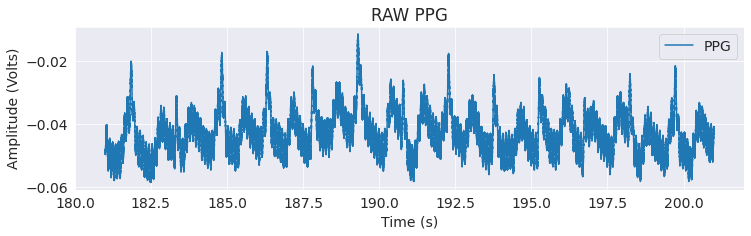

In [119]:
fig=bio_df[['PPG','time']][1900000:2100000].plot(x='time', figsize=(12,3))
plt.ylabel('Amplitude (Volts)')
plt.xlabel('Time (s)')
plt.title("RAW PPG")

Text(0.5, 1.0, 'FILTERED PPG')

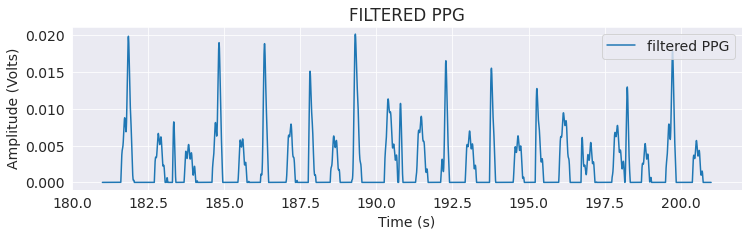

In [121]:
df_filt = pd.DataFrame({'time': bio_df['time'], 'filtered PPG':filt})
df_filt[1900000:2100000].plot(x='time', figsize=(12,3))
plt.ylabel('Amplitude (Volts)')
plt.xlabel('Time (s)')
plt.title("FILTERED PPG")

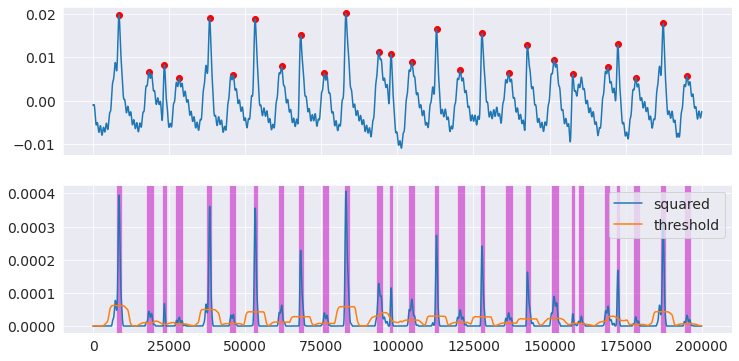

In [37]:
info = nk.ppg_findpeaks(filt[1900000:2100000], fs, show=True)

Text(0.5, 1.0, 'Longer excerpt of uncorrected systolic peak detection on filtered PPG')

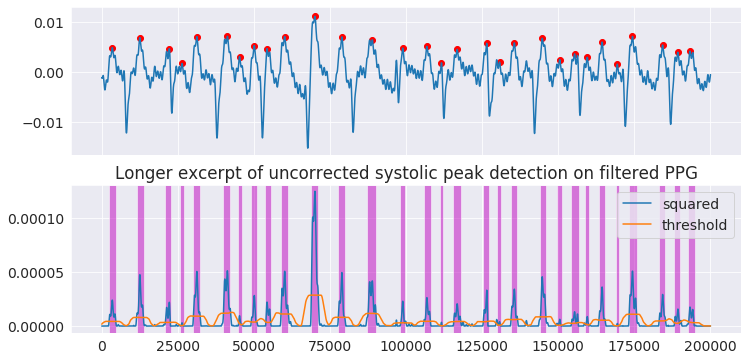

In [51]:
info = nk.ppg_findpeaks(filt[1900000:2100000], fs, show=True)
plt.title('Longer excerpt of uncorrected systolic peak detection on filtered PPG')

Text(0.5, 1.0, 'Excerpt of uncorrected systolic peak detection on interpolated and filtered PPG')

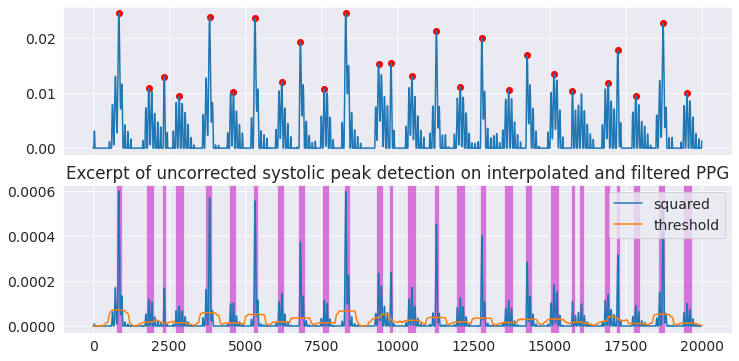

In [109]:
info = nk.ppg_findpeaks(interp[190000:210000], show=True)
plt.title('Excerpt of uncorrected systolic peak detection on interpolated and filtered PPG')

Text(0.5, 1.0, 'Longer excerpt of uncorrected systolic peak detection on interpolated and filtered PPG')

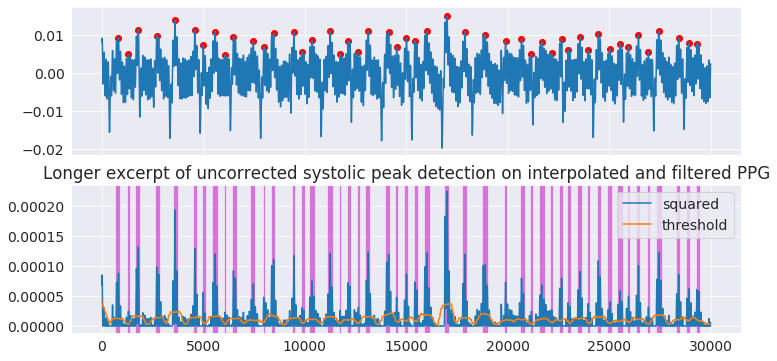

In [53]:
info = nk.ppg_findpeaks(interp[180000:210000], show=True)
plt.title('Longer excerpt of uncorrected systolic peak detection on interpolated and filtered PPG')

Text(0.5, 1.0, 'Excerpt of uncorrected systolic peak detection on detrended Raw PPG')

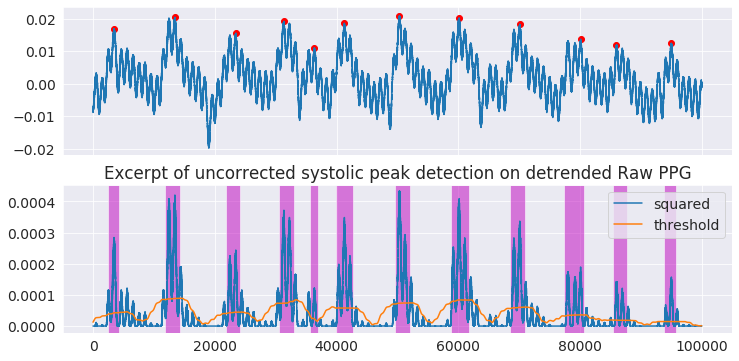

In [54]:
info = nk.ppg_findpeaks(detrend[250000:350000], fs, show=True)
plt.title('Excerpt of uncorrected systolic peak detection on detrended Raw PPG')

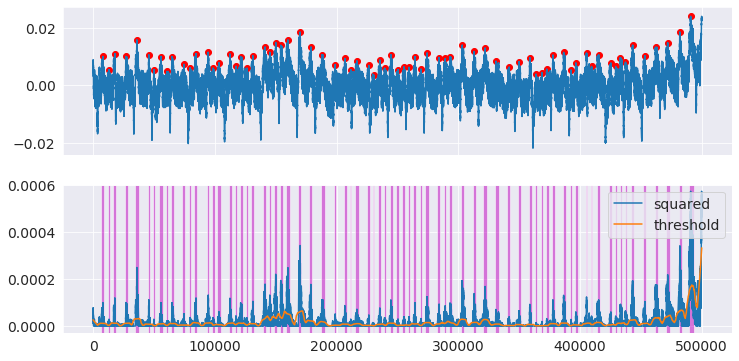

In [55]:
info = nk.ppg_findpeaks(detrend[1800000:2300000], fs, show=True)

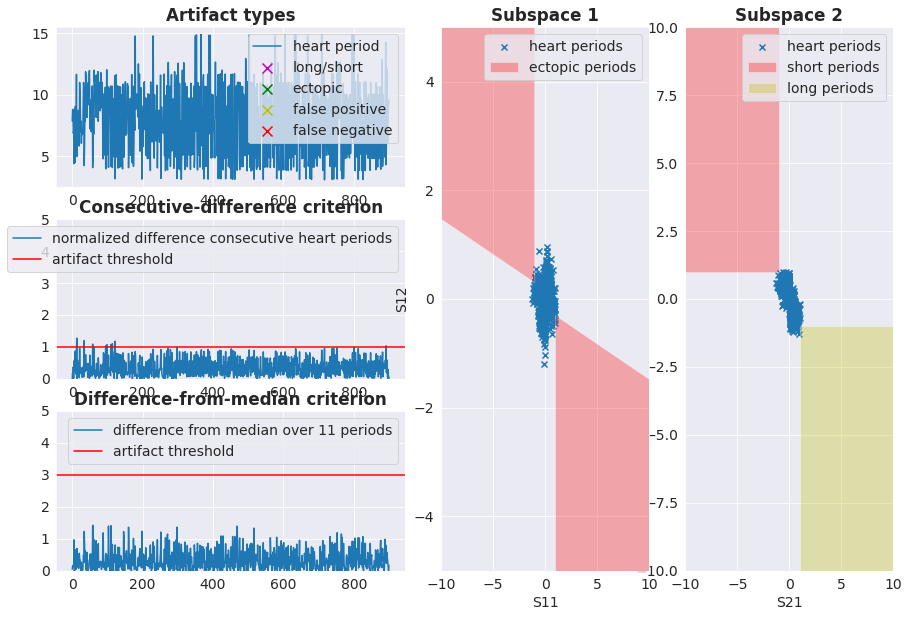

In [113]:
info = nk.ppg_findpeaks(filt, fs)
artefacts, info1 = nk.signal_fixpeaks(info, sampling_rate=fs,  iterative=True, show=True, method="Kubios")

In [114]:
rate_corrected = nk.signal_rate(info1,fs, desired_length=len(bio_df))
rate_uncorrected = nk.signal_rate(info,fs, desired_length=len(bio_df))
fig, ax = plt.subplots()
ax.plot(rate_uncorrected[1800000:5800000], label="heart rate without artefact correction")
ax.plot(rate_corrected[1800000:5800000], label="heart rate with artefact correction")
ax.legend(loc="upper right")

ValueError: NeuroKit error: desired_length must be None or larger than the index of the last peak.

## High-level main function for all biosignals

In [ ]:
bio_proc, bio_info = neuromod_bio_process(df=bio_df, sampling_rate=fs)

In [ ]:
bio_proc.keys()

In [ ]:
bio_info.keys()

In [ ]:
df1 = nk.standardize(bio_proc[['PPG_Rate', 'PPG_Clean']][3000000:3300000])
df1['time'] = bio_proc['time'][3000000:3300000]
df1.plot(x='time')
plt.xlabel('time (s)')

In [ ]:
df1 = nk.standardize(bio_proc[['RSP_Rate', 'RSP_Clean']][2500000:3500000])
df1['time'] = bio_proc['time'][2500000:3500000]
df1.plot(x='time')

In [ ]:
df1 = nk.standardize(bio_proc[['EDA_Clean', 'EDA_Phasic']][2500000:4500000])
df1['time'] = bio_proc['time'][2500000:4500000]
df1.plot(x='time')

# Visualize 

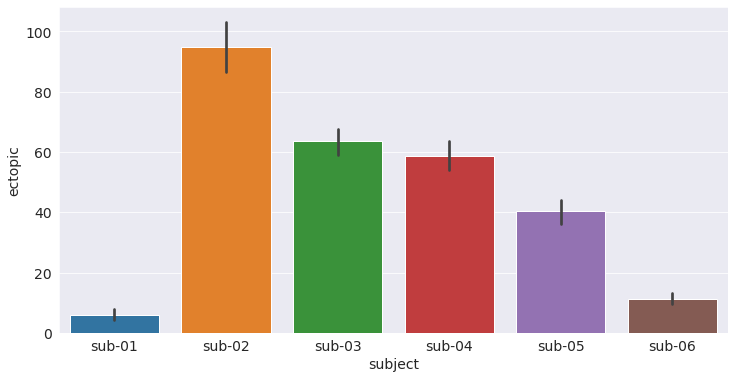

In [34]:
sns.barplot(data=clean_df, x='subject', y='ectopic')

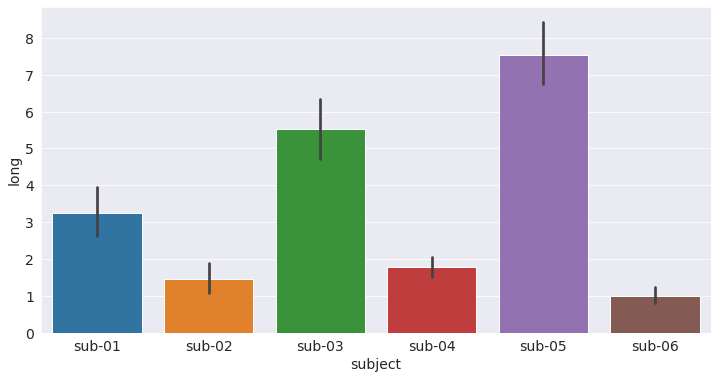

In [35]:
sns.barplot(data=clean_df, x='subject', y='long')

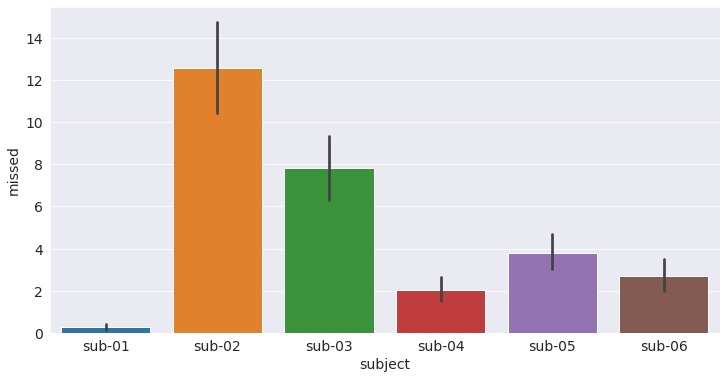

In [36]:
sns.barplot(data=clean_df, x='subject', y='missed')

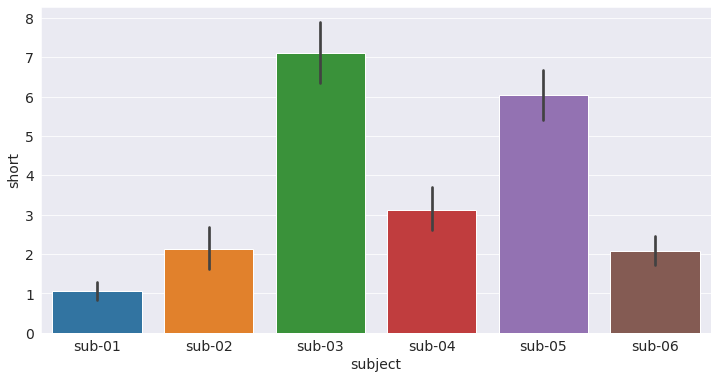

In [37]:
sns.barplot(data=clean_df, x='subject', y='short')

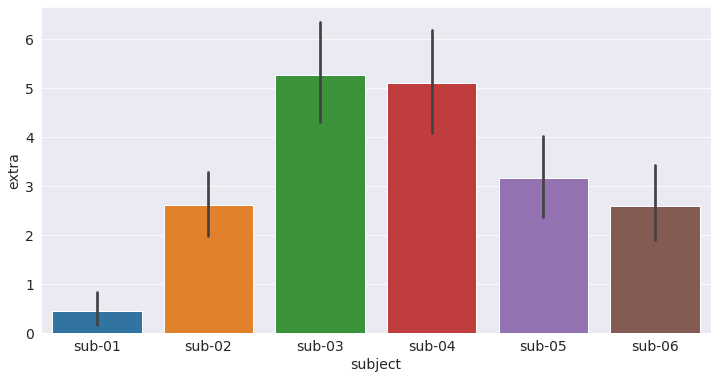

In [38]:
sns.barplot(data=clean_df, x='subject', y='extra')

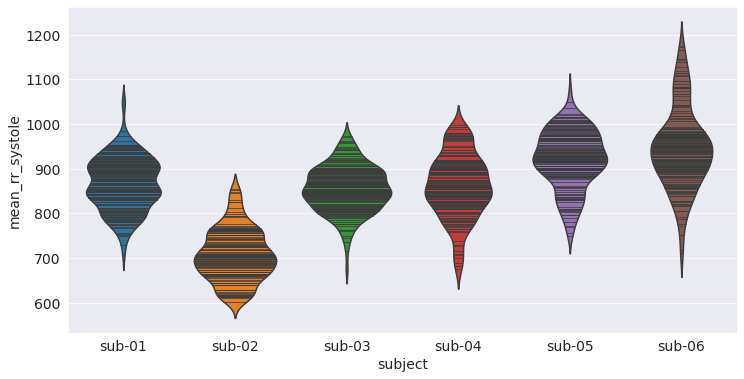

In [39]:
dist = sns.violinplot(data=clean_df, x='subject',y='mean_rr_systole', inner='stick', bw=0.3)

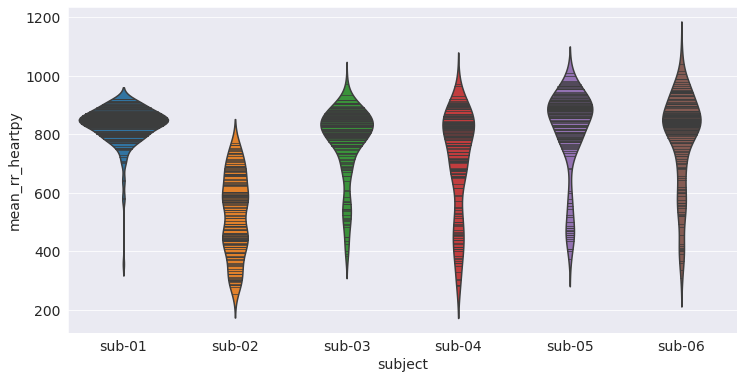

In [40]:
dist = sns.violinplot(data=clean_df, x='subject',y='mean_rr_heartpy', inner='stick', bw=0.3)

/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


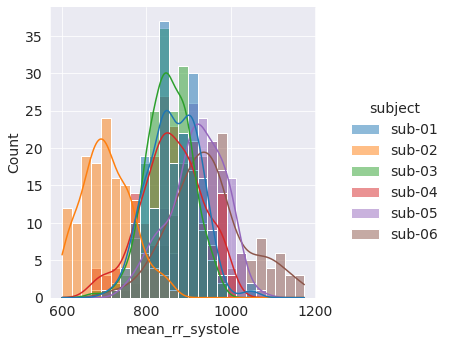

In [41]:
sns.displot(data=clean_df, x='mean_rr_systole', hue='subject', kde=True)

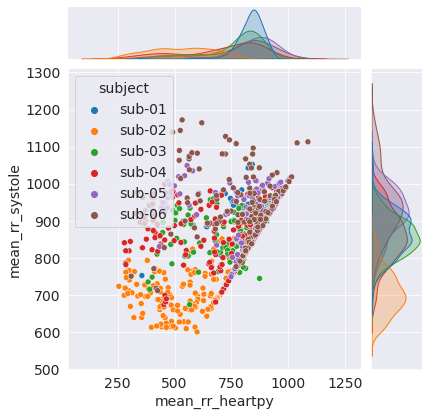

In [54]:
sns.jointplot(x='mean_rr_heartpy', y='mean_rr_systole',hue='subject', data=clean_df)

/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:

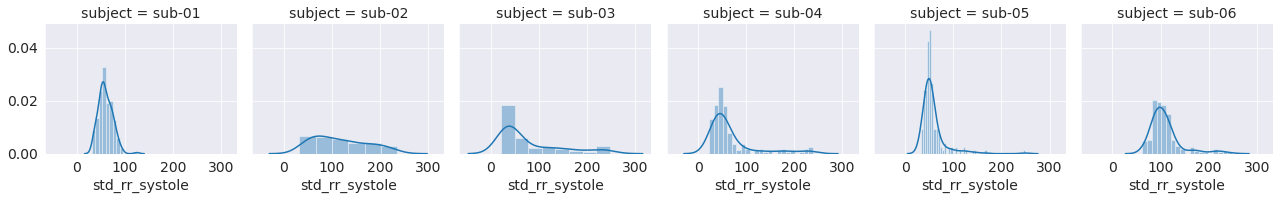

In [33]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.distplot, "std_rr_systole", )

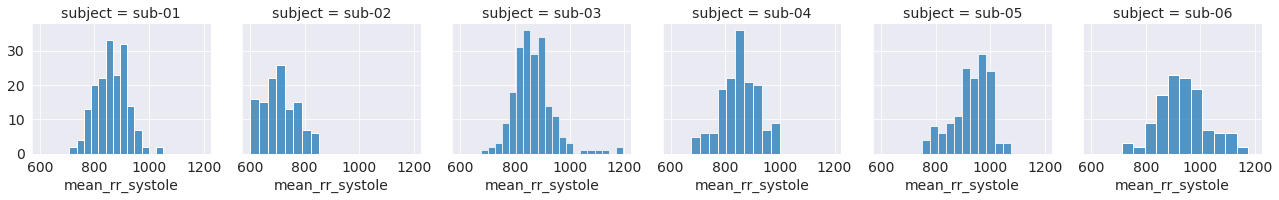

In [40]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "mean_rr_systole", )

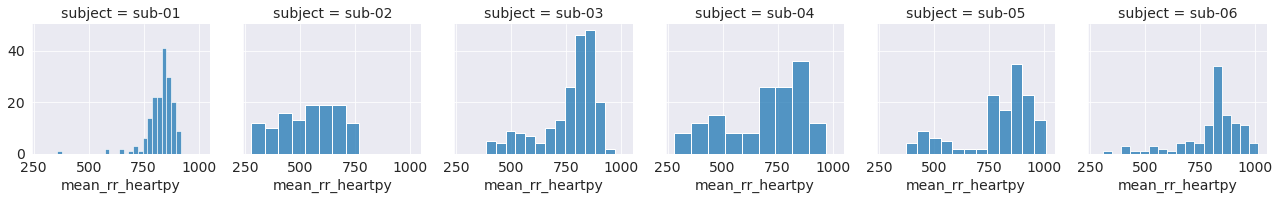

In [41]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "mean_rr_heartpy")

In [42]:
clean_df[clean_df['subject']=='sub-01'].describe()

,ectopic,extra,long,mean_rr_heartpy,mean_rr_systole,missed,run_id,short,std_rr_systole
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,5.771739,0.445652,3.239130,831.248419,866.192012,0.277174,3.391304,1.065217,60.313071
std,13.331505,2.355619,4.606647,66.399691,58.724151,0.988635,1.966698,1.648343,14.623808
min,0.000000,0.000000,0.000000,356.400000,708.485512,0.000000,1.000000,0.000000,32.095967
25%,0.000000,0.000000,0.000000,803.808785,829.955900,0.000000,2.000000,0.000000,50.187439
50%,2.000000,0.000000,2.000000,843.566019,864.630255,0.000000,3.000000,0.000000,58.829718
75%,6.000000,0.000000,4.000000,869.918160,908.696691,0.000000,4.250000,1.000000,70.581548
max,137.000000,22.000000,30.000000,920.438000,1052.204468,8.000000,10.000000,11.000000,125.270323


In [43]:
clean_df[clean_df['subject']=='sub-02'].describe()

,ectopic,extra,long,mean_rr_heartpy,mean_rr_systole,missed,run_id,short,std_rr_systole
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,94.872340,2.602837,1.446809,525.220434,706.924858,12.574468,3.255319,2.134752,117.397675
std,50.320523,3.826374,2.427302,136.785045,58.165078,13.083378,1.754196,3.073434,55.917256
min,2.000000,0.000000,0.000000,254.950266,600.720197,0.000000,1.000000,0.000000,32.233248
25%,59.000000,0.000000,0.000000,427.869809,664.674668,4.000000,2.000000,0.000000,68.766553
50%,85.000000,1.000000,1.000000,539.138446,702.500000,8.000000,3.000000,1.000000,109.824989
75%,119.000000,3.000000,2.000000,634.969900,750.902428,18.000000,5.000000,3.000000,161.202521
max,227.000000,21.000000,14.000000,769.373245,853.454270,81.000000,8.000000,14.000000,235.851398


In [44]:
clean_df[clean_df['subject']=='sub-03'].describe()

,ectopic,extra,long,mean_rr_heartpy,mean_rr_systole,missed,run_id,short,std_rr_systole
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,63.494505,5.263736,5.527473,770.419505,854.667297,7.835165,2.406593,7.109890,78.391088
std,31.651198,6.948644,5.781167,126.576252,51.619513,10.424963,1.193704,5.531328,64.742532
min,2.000000,0.000000,0.000000,383.605467,674.388364,0.000000,1.000000,0.000000,21.336340
25%,39.000000,0.000000,1.000000,733.849413,818.981411,0.000000,1.000000,3.000000,32.472396
50%,60.500000,3.000000,4.000000,808.564605,852.768057,4.000000,2.000000,6.000000,46.437557
75%,85.000000,7.750000,8.000000,853.210034,892.386256,10.000000,3.000000,10.000000,113.389237
max,151.000000,40.000000,27.000000,970.995826,972.408907,45.000000,6.000000,25.000000,246.945419


In [45]:
clean_df[clean_df['subject']=='sub-04'].describe()

,ectopic,extra,long,mean_rr_heartpy,mean_rr_systole,missed,run_id,short,std_rr_systole
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,58.536313,5.100559,1.782123,701.362138,860.677246,2.011173,3.391061,3.128492,67.169378
std,33.646753,7.413998,1.885043,180.057350,71.715885,3.755130,1.926494,3.805706,49.593569
min,11.000000,0.000000,0.000000,279.467263,674.391545,0.000000,1.000000,0.000000,23.127818
25%,34.500000,0.000000,0.000000,580.723810,817.373472,0.000000,2.000000,1.000000,38.837161
50%,51.000000,1.000000,1.000000,764.118318,858.887146,0.000000,3.000000,2.000000,49.872096
75%,72.500000,8.500000,3.000000,836.370143,908.343021,2.000000,5.000000,4.000000,65.470318
max,202.000000,35.000000,10.000000,971.305033,998.590278,27.000000,10.000000,21.000000,238.274555


In [46]:
clean_df[clean_df['subject']=='sub-05'].describe()

,ectopic,extra,long,mean_rr_heartpy,mean_rr_systole,missed,run_id,short,std_rr_systole
count,170.000000,170.000000,170.000000,167.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,40.252941,3.164706,7.541176,807.489959,919.882374,3.794118,4.988235,6.041176,57.179462
std,26.089528,5.467163,5.543914,152.507048,65.155720,5.611587,2.973230,4.336928,25.581157
min,0.000000,0.000000,0.000000,371.401050,749.569138,0.000000,1.000000,0.000000,32.080011
25%,23.000000,0.000000,4.000000,778.146840,882.539757,0.000000,2.250000,2.250000,44.806547
50%,38.500000,1.000000,6.000000,861.562500,922.624611,2.000000,4.500000,6.000000,51.062084
75%,54.000000,4.000000,11.000000,904.629779,967.745473,5.000000,7.000000,9.000000,57.173843
max,123.000000,30.000000,31.000000,1008.336502,1073.841417,36.000000,12.000000,22.000000,248.417387


In [47]:
clean_df[clean_df['subject']=='sub-06'].describe()

,ectopic,extra,long,mean_rr_heartpy,mean_rr_systole,missed,run_id,short,std_rr_systole
count,172.000000,172.000000,172.000000,168.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,11.156977,2.593023,1.005814,781.441788,945.563745,2.680233,4.511628,2.081395,109.283218
std,12.524773,5.206559,1.546538,163.754351,90.614783,5.119286,2.868438,2.514124,32.900438
min,0.000000,0.000000,0.000000,308.941610,712.057200,0.000000,1.000000,0.000000,62.304106
25%,2.000000,0.000000,0.000000,707.926146,892.854249,0.000000,2.000000,0.000000,89.923232
50%,6.500000,0.000000,0.000000,831.686455,939.216092,1.000000,4.000000,1.000000,102.080938
75%,14.250000,3.000000,1.000000,881.464094,981.988646,4.000000,6.000000,3.000000,117.431861
max,57.000000,25.000000,10.000000,1086.998246,1174.811008,45.000000,14.000000,13.000000,248.740746


In [48]:
clean_df[clean_df['task']=='task-s03e20b']

,ectopic,extra,long,mean_rr_heartpy,mean_rr_systole,missed,run_id,session_id,short,std_rr_systole,subject,task
125,0.0,0.0,2.0,836.363184,840.146908,0.0,6.0,ses-025,0.0,52.434006,sub-01,task-s03e20b
479,79.0,7.0,3.0,801.062143,807.938223,9.0,4.0,ses-036,16.0,113.676618,sub-03,task-s03e20b
718,71.0,5.0,2.0,753.714831,837.477660,0.0,2.0,ses-031,6.0,43.446798,sub-04,task-s03e20b


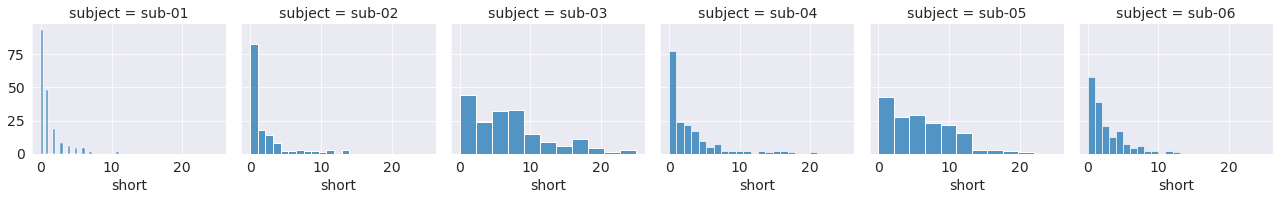

In [49]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "short", )

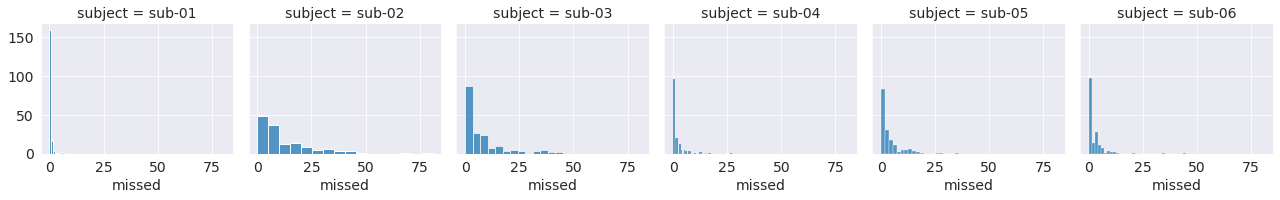

In [50]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "missed", )

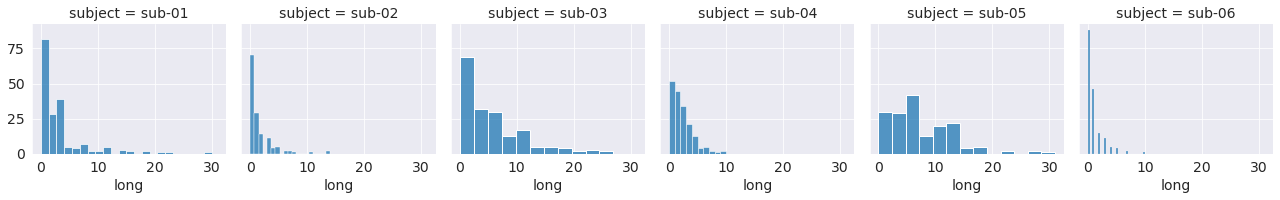

In [51]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "long", )

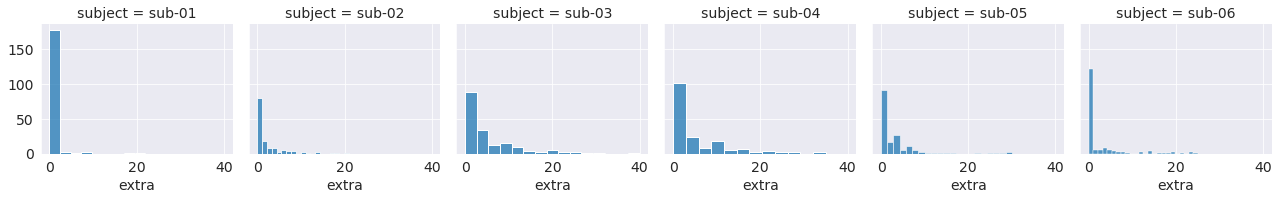

In [52]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "extra", )

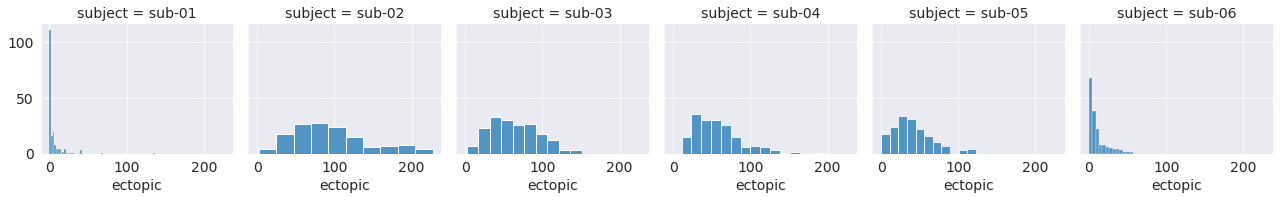

In [53]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "ectopic", )